LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [ ]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

In [ ]:
!pip install mosek 
!export PYTHONPATH="$PYTHONPATH:/content"

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem. 
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

In [1]:
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [ ]:
# Colab additional settings
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [6]:
def RiskBudgeting(N, G, b, a):
    
    with Model('Risk budgeting') as M:
        # Settings
        M.setLogHandler(sys.stdout)
        
        # Portfolio weights
        x = M.variable("x", N, Domain.unbounded())
        xp = M.variable("xp", N, Domain.greaterThan(0.0))
        xm = M.variable("xm", N, Domain.greaterThan(0.0))
        
        # Binary variables
        yp = M.variable("yp", N, Domain.binary())
        ym = M.variable("ym", N, Domain.binary())
        
        # Constraint assigning xp and xm to be the positive and negative part of x.
        M.constraint('pos-neg-part', Expr.sub(x, Expr.sub(xp, xm)), Domain.equalsTo(0.0))
        
        # Orthant specifier constraints
        bigM = 20
        M.constraint('ubound-p', Expr.sub(Expr.mul(bigM, yp), xp), Domain.greaterThan(0.0))
        M.constraint('ubound-m', Expr.sub(Expr.mul(bigM, ym), xm), Domain.greaterThan(0.0))
        
        # Exclusive buy-sell constraint
        M.constraint('exclusion', Expr.add(yp, ym), Domain.lessThan(1.0))
        
        # Auxiliary variables
        t = M.variable("t", N, Domain.unbounded())
        s = M.variable("s", 1, Domain.unbounded())
    
        # Objective function: 1/2 * x'Sx - a * b'log(|x|) becomes s - a * b't
        M.objective(ObjectiveSense.Minimize, Expr.sub(s, Expr.mul(a, Expr.dot(b, t))))
    
        # Bound on risk term 
        M.constraint(Expr.vstack(s, 1, Expr.mul(G.T, x)), Domain.inRotatedQCone())
    
        # Bound on log term: t <= log(x) becomes (|x|, 1, t) in K_exp
        M.constraint(Expr.hstack(Expr.add(xp, xm), Expr.constTerm(N, 1.0), t), Domain.inPExpCone())
    
        # Create DataFrame to store the results.
        columns = ["obj", "risk", "xsum", "bsum"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns) 
   
        # Solve optimization
        M.solve()

        # Save results
        xv = x.level()
        
        # Check solution quality
        risk_budgets = xv * np.dot(G @ G.T, xv)
        
        # Renormalize to gross exposure = 1
        xv = xv / np.abs(xv).sum()
        
        # Compute portfolio metrics
        Gx = np.dot(G.T, xv)
        portfolio_risk = np.sqrt(np.dot(Gx, Gx))     
        
        row = pd.Series([M.primalObjValue(), portfolio_risk, np.sum(xv), np.sum(risk_budgets)] + list(xv), index=columns)
        df_result = df_result.append(row, ignore_index=True)
        row = pd.Series([None] * 4 + list(risk_budgets), index=columns)
        df_result = df_result.append(row, ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
m, S = compute_inputs(df_prices, shrinkage=False)

# Risk budget
b = np.ones(N) / N

# Global setting for sum of b
a = 1

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G = np.linalg.cholesky(S)

## Call the optimizer function

In [9]:
df_result = RiskBudgeting(N, G, b, a)

Problem
  Name                   : Risk budgeting  
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 66              
  Cones                  : 9               
  Scalar variables       : 84              
  Matrix variables       : 0               
  Integer variables      : 16              

Optimizer started.
Mixed integer optimizer started.
Threads used: 20
Presolve started.
Presolve terminated. Time = 0.00
Presolved problem: 65 variables, 39 constraints, 122 non-zeros
Presolved problem: 0 general integer, 17 binary, 48 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   -2.9957317194e+00    NA          0.1   
0        1        1        0        2.2615865763e-01     -2.9957317194e+00    1.42e+03    0.1   
Cut generation started.
0        1        1        0        2.2

Check the results.

In [10]:
df_result

,obj,risk,xsum,bsum,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,-0.162779,0.063972,-0.01382,0.999933,0.110717,0.121953,-0.157497,-0.124437,-0.102620,0.132594,0.127826,-0.122356
1,NaN,NaN,NaN,NaN,0.124993,0.124993,0.124994,0.124991,0.124992,0.124992,0.124993,0.124986


## Visualize the results

Plot the portfolio components.

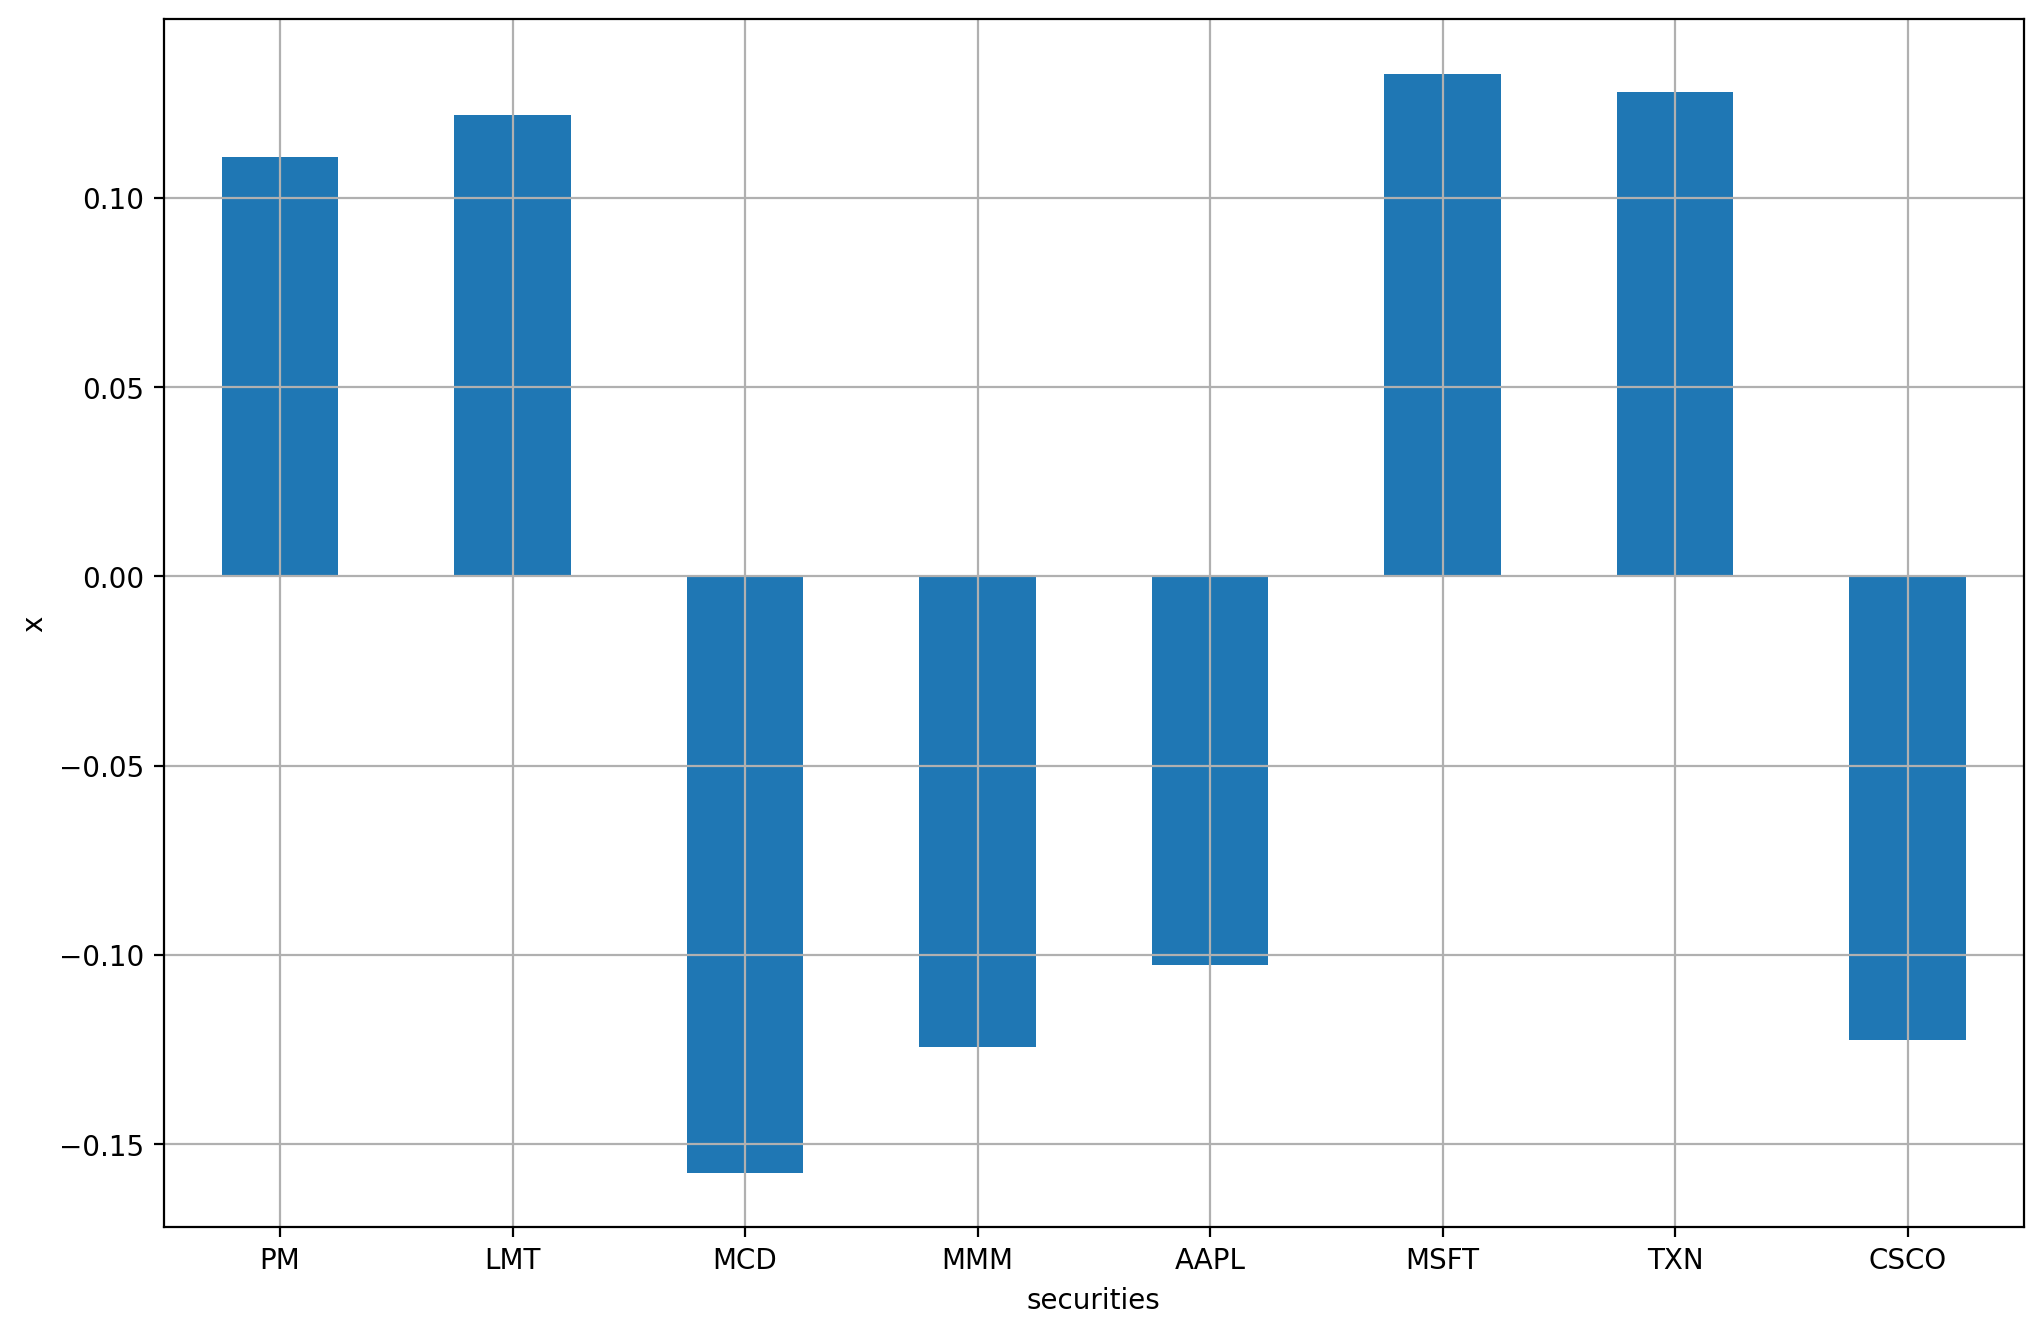

In [11]:
ax = df_result.iloc[0, 4:].T.plot.bar(xlabel="securities", ylabel="x", grid=True, rot=0)

Plot the risk budgets.

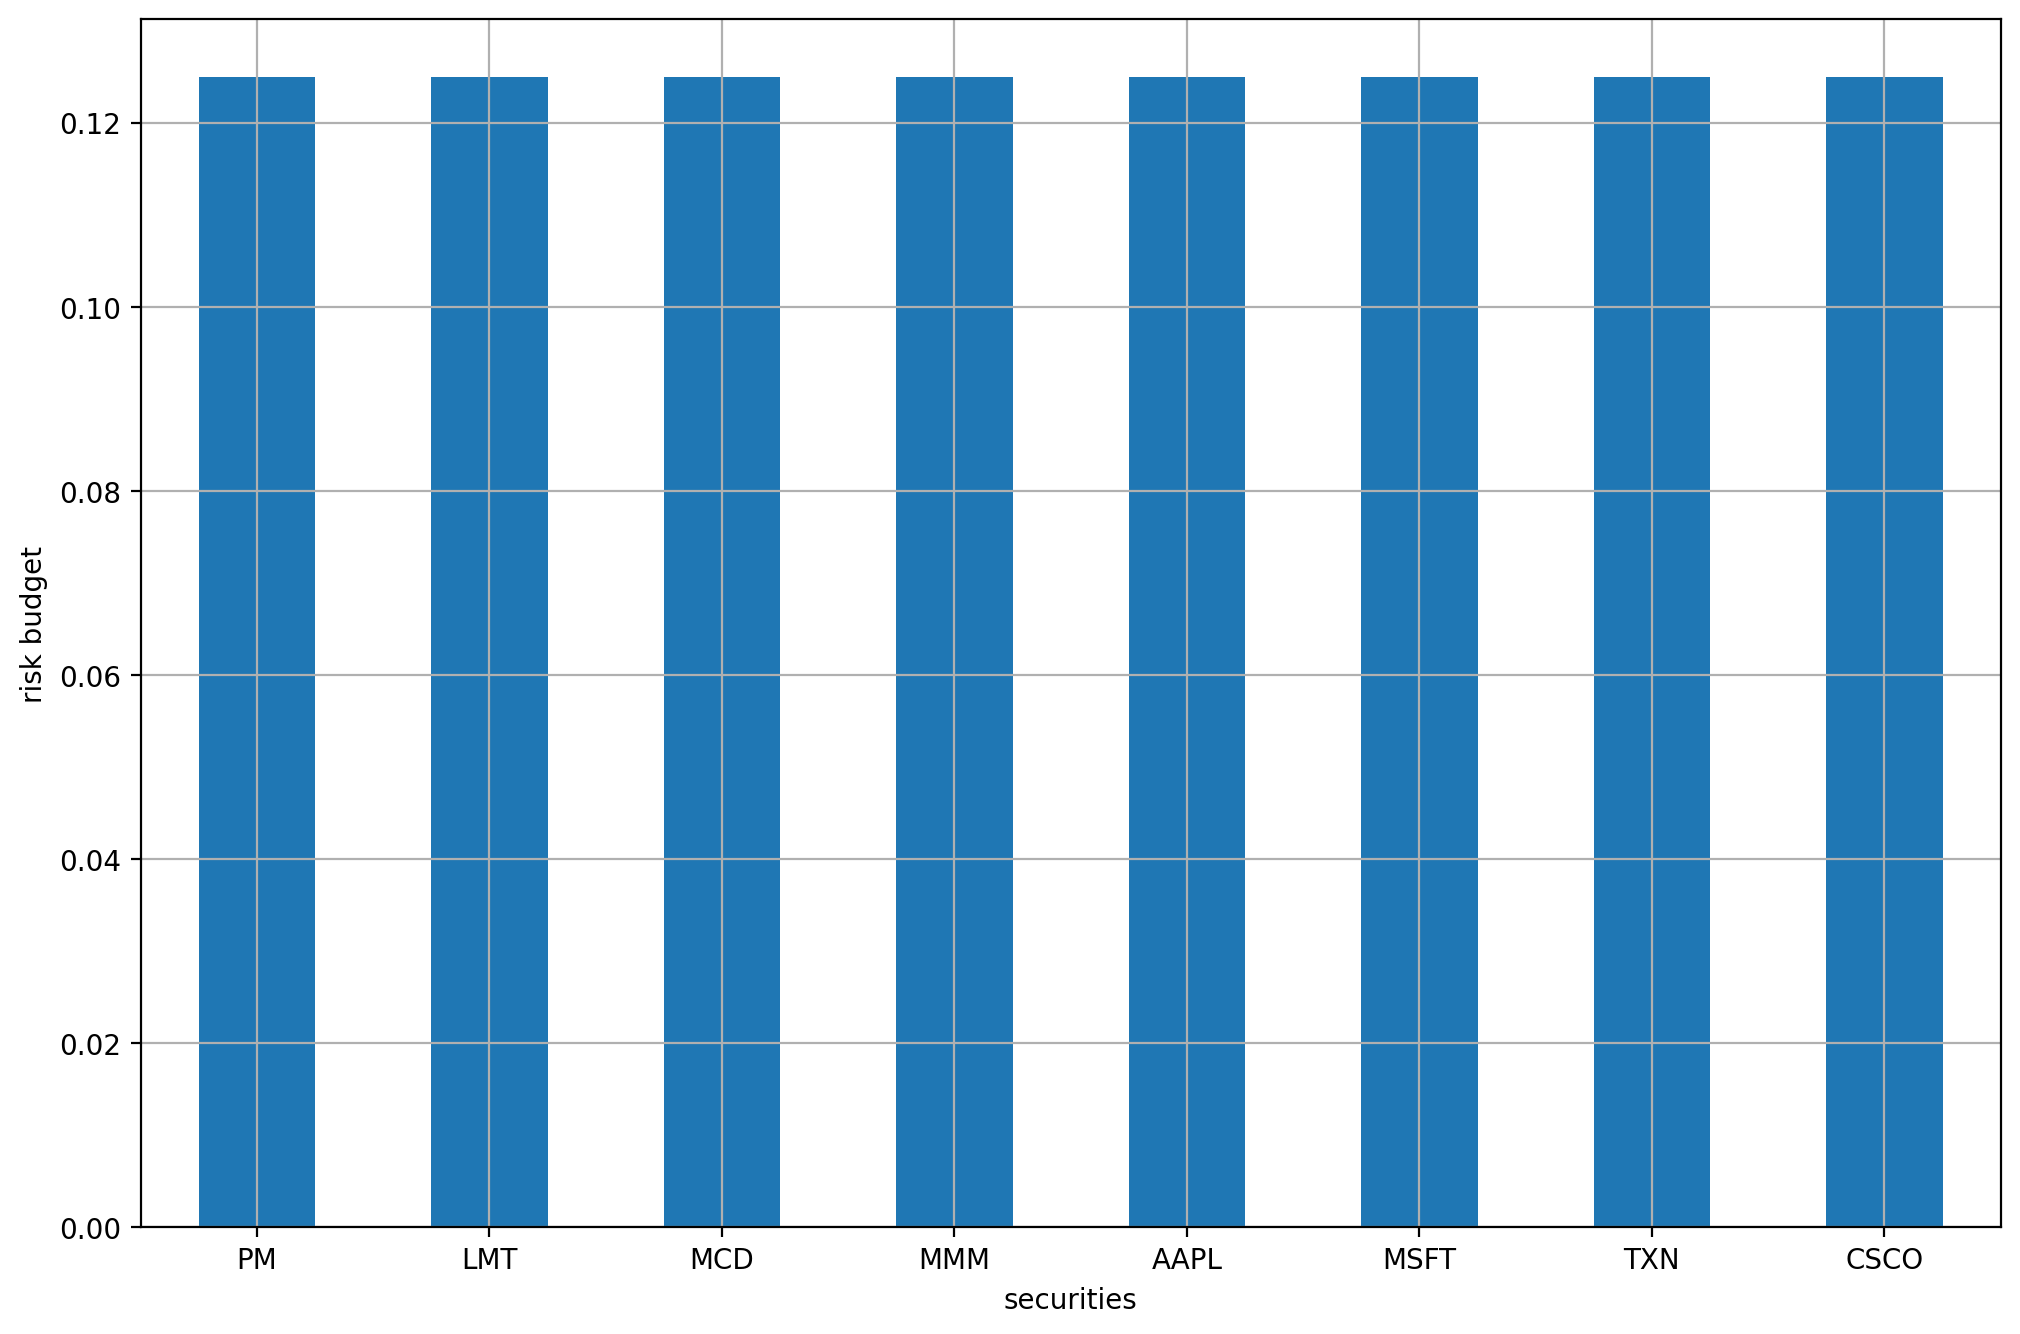

In [12]:
ax = df_result.iloc[1, 4:].T.plot.bar(xlabel="securities", ylabel="risk budget", grid=True, rot=0)